In [5]:
#/bin/python
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
np.random.seed(247) # for reproducibility

import matplotlib.pyplot as plt
%matplotlib inline

import theano.tensor as T
import theano

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import DropoutLayer, BatchNormLayer, ParametricRectifierLayer
from lasagne.layers import get_output, get_output_shape, get_all_layers, get_all_params
from lasagne.layers import get_all_param_values, set_all_param_values
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, sigmoid, rectify, linear
from lasagne.nonlinearities import leaky_rectify, tanh, very_leaky_rectify
from lasagne.init import Constant, Normal, Uniform, GlorotNormal
from lasagne.init import GlorotUniform, HeNormal, HeUniform
import lasagne.updates as updates
import lasagne.objectives as objectives

In [6]:
name = 'RNA_compete'
datapath = '/home/peter/Data/DeepBind/rnac/'
filepath = os.path.join(datapath, 'rnac.hdf5')
train, valid, test = load_data(name, filepath)

In [7]:
num_train, dim, seq_length, other = train[0].shape
shape = (None, dim, seq_length, other)
num_labels = train[1].shape[1]

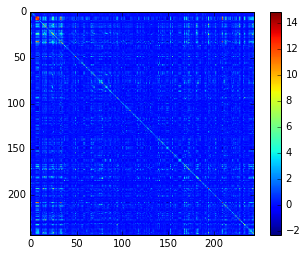

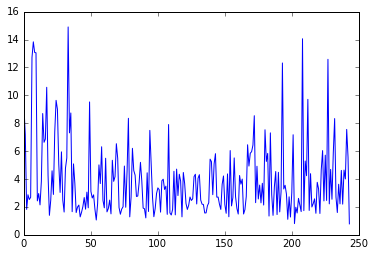

In [8]:
# calculate covariance matrix
C = np.cov(train[1].T)

# image of covariance matrix (large variances are skewing distribution)
plt.figure()
plt.imshow(C)
plt.colorbar()

# plot of the variance
plt.figure()
plt.plot(np.diag(C))

In [9]:
# transform data to decorrelate and make standard normal variables
L = np.linalg.cholesky(C)
Linv = np.linalg.inv(L)
decorr_targets = np.dot(Linv, train[1].T).T
decorr_targets.shape

(168949, 244)

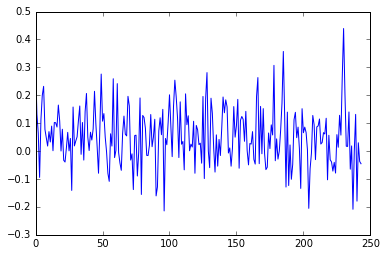

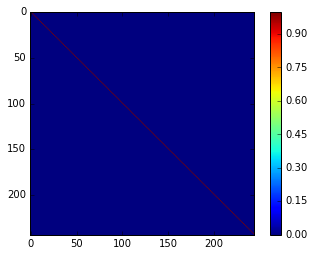

In [10]:
plt.figure()
plt.plot(np.mean(decorr_targets, axis=0))

C2 = np.cov(decorr_targets.T)
plt.figure()
plt.imshow(C2)
plt.colorbar()

### Buid neural network model

In [26]:
def rnac_model(shape, num_labels):

    filter_size = 4
    pool_size = 2
    
    input_var = T.tensor4('inputs')
    target_var = T.dmatrix('targets')

    net = {}

    # 1st conv layer
    net['input'] = InputLayer(input_var=input_var, shape=shape)
    net['conv1'] = ConvLayer(net['input'], num_filters=256, filter_size=(12,1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch1'] = BatchNormLayer(net['conv1'], epsilon=0.001)    
    net['active1'] = ParametricRectifierLayer(net['batch1'], alpha=Constant(0.25), shared_axes='auto')
    net['pool1'] = PoolLayer(net['active1'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)

    # 2nd conv layer
    net['conv2'] = ConvLayer(net['pool1'], num_filters=512, filter_size=(6, 1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch2'] = BatchNormLayer(net['conv2'], epsilon=0.001)
    net['active2'] = ParametricRectifierLayer(net['batch2'], alpha=Constant(0.25), shared_axes='auto')
    net['pool2'] = PoolLayer(net['active2'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)

    # 3rd conv layer
    net['conv3'] = ConvLayer(net['pool2'], num_filters=768, filter_size=(5, 1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch3'] = BatchNormLayer(net['conv3'], epsilon=0.001)
    net['active3'] = ParametricRectifierLayer(net['batch3'], alpha=Constant(0.25), shared_axes='auto')
    net['pool3'] = PoolLayer(net['active3'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)
    net['drop3'] = DropoutLayer(net['pool3'], p=0.2)
    
    # 1st dense layer  
    net['dense4'] = DenseLayer(net['drop3'], num_units=512, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['batch4'] = BatchNormLayer(net['dense4'], epsilon=0.001)
    net['active4'] = ParametricRectifierLayer(net['batch4'], alpha=Constant(0.25), shared_axes='auto')
    net['drop4'] = DropoutLayer(net['active4'], p=0.5)

    # 2nd dense layer
    net['dense5'] = DenseLayer(net['drop4'], num_units=512, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['batch5'] = BatchNormLayer(net['dense5'], epsilon=0.001)
    net['active5'] = ParametricRectifierLayer(net['batch5'], alpha=Constant(0.25), shared_axes='auto')
    net['drop5'] = DropoutLayer(net['active5'], p=0.5)

    # output layer
    net['dense6'] = DenseLayer(net['drop5'], num_units=num_labels, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['output'] = NonlinearityLayer(net['dense6'], nonlinearity=linear)

    return net, input_var, target_var



def GLS_cost(prediction, target_var, Linv):
    error = (target_var - prediction)
    decor_error = T.dot(Linv, error.T).T
    loss = decor_error ** 2
    return loss.mean()


def OLS_cost(prediction, target_var):
    error = (target_var - prediction)
    loss = error ** 2
    return loss.mean()

In [56]:
# build model
net, input_var, target_var = rnac_model(shape, num_labels)
get_output_shape(net['output'])

(None, 244)

### Build generalized least squares cost function

In [83]:
decorrelate = True
prediction = get_output(net['output'])
if decorrelate:
    # train cost function
    train_loss = GLS_cost(prediction, target_var, Linv)

    # test cost function
    valid_prediction = get_output(net['output'], deterministic=True)
    valid_loss = GLS_cost(valid_prediction, target_var, Linv)
else:
    # train cost function
    train_loss = objectives.squared_error(prediction, target_var)
    train_loss = train_loss.mean()

    # test cost function
    valid_prediction = get_output(net['output'], deterministic=True)
    valid_loss = GLS_cost(valid_prediction, target_var)

# updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=0.001)

# compile theano function
train_fun = theano.function([input_var, target_var], train_loss, updates=update_op)
valid_fun = theano.function([input_var, target_var], [valid_loss, valid_prediction])

### Train model

In [84]:
def batch_generator(X, y, N):
    while True:
        idx = np.random.choice(len(y), N)
        #yield X[idx].astype('float32'), np.expand_dims(y[idx].astype('float32'), axis=1)
        yield X[idx].astype('float32'), y[idx].astype('float32')

index=35
batch_size = 128
num_train_batches = len(train[0]) // batch_size
train_batches = batch_generator(train[0], train[1], batch_size)

num_valid_batches = len(valid[0]) // batch_size
valid_batches = batch_generator(valid[0], valid[1], batch_size)

num_epochs = 10
for epoch in range(num_epochs):
    print('epoch: %d' % epoch)
    ave_loss = 0
    for i in range(num_train_batches):
        X_batch, y_batch = next(train_batches)
        
        train_loss = train_fun(X_batch, y_batch)
        ave_loss += train_loss
    print("train: %f" % (ave_loss/num_train_batches))

    ave_loss = 0
    for i in range(num_valid_batches):
        X_batch, y_batch = next(valid_batches)
        valid_loss, valid_prediction = valid_fun(X_batch, y_batch)
        ave_loss += valid_loss
    print("valid: %f" % (ave_loss/num_valid_batches))
    

epoch: 0
train: 0.853966
valid: 0.841532
epoch: 1
train: 0.851060
valid: 0.837120
epoch: 2
train: 0.848264
valid: 0.843260
epoch: 3
train: 0.846691
valid: 0.834125
epoch: 4
train: 0.846522
valid: 0.837499
epoch: 5
train: 0.845058
valid: 0.830842
epoch: 6
train: 0.843803
valid: 0.832062
epoch: 7
train: 0.841241
valid: 0.838007
epoch: 8
train: 0.840138
valid: 0.837620
epoch: 9
train: 0.837287
valid: 0.835110


In [85]:
#y = np.expand_dims(test[1][:,index].astype('float32'), axis=1)
y = test[1].astype('float32')
test_loss, test_prediction = valid_fun(test[0].astype(np.float32), y)    

In [101]:
test_prediction = np.dot(Linv, test_prediction.T).T
y = np.dot(Linv, y.T).T

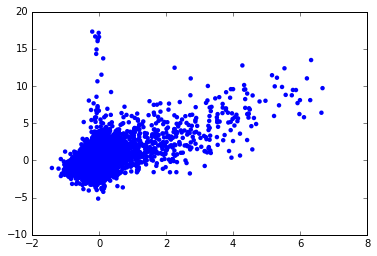

In [120]:
index=109
plt.figure()
#plt.scatter(test_prediction ,y, edgecolor = 'none')
plt.scatter(test_prediction[:,index] ,y[:,index], edgecolor = 'none')
#plt.xlim(-5, 15)
#plt.ylim(-5,15)

In [137]:
test_prediction

array([[ 0.46506384],
       [ 0.78256798],
       [ 0.78256798],
       ..., 
       [ 0.78256798],
       [ 0.78256798],
       [ 0.75038177]], dtype=float32)

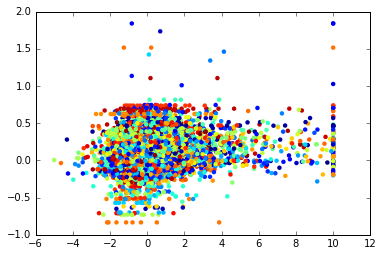

In [41]:
x = []
y = []
labels = []
for i in range(num_labels):
    labels.append(np.ones(len(test[1]))*i)
        
num_test = len(test[1])
x = np.reshape(test[1], (-1,))
y = np.reshape(test_prediction, (-1,))
labels = np.outer(np.ones(num_test), range(num_labels))
labels = np.reshape(labels, (-1,))

num_samples = 10000
index = np.random.permutation(num_labels*num_test)[0:num_samples]

plt.figure()
plt.scatter(x[index] ,y[index] , c=labels[index], cmap=plt.cm.get_cmap("jet", num_labels), edgecolor = 'none')

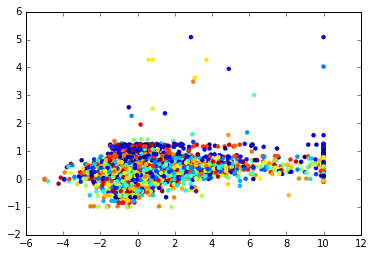

In [32]:
x = []
y = []
labels = []
for i in range(num_labels):
    labels.append(np.ones(len(test[1]))*i)
        
num_test = len(test[1])
x = np.reshape(test[1], (-1,))
y = np.reshape(test_prediction, (-1,))
labels = np.outer(np.ones(num_test), range(num_labels))
labels = np.reshape(labels, (-1,))

num_samples = 10000
index = np.random.permutation(num_labels*num_test)[0:num_samples]

plt.figure()
plt.scatter(x[index] ,y[index] , c=labels[index], cmap=plt.cm.get_cmap("jet", num_labels), edgecolor = 'none')

In [31]:
labels.shape

(36203, 244)

In [ ]:
def rnac_model(shape, num_labels):
    
    input_var = T.tensor4('inputs')
    target_var = T.dmatrix('targets')

    net = {}

    # 1st conv layer
    net['input'] = InputLayer(input_var=input_var, shape=shape)
    net['conv1'] = ConvLayer(net['input'], num_filters=20, filter_size=(16,1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.1), nonlinearity=None)
    net['batch1'] = BatchNormLayer(net['conv1'], epsilon=0.001)    
    net['active1'] = NonlinearityLayer(net['batch1'], nonlinearity=rectify)
    net['pool1'] = PoolLayer(net['active1'], pool_size=(26,1), stride=(26,1), ignore_border=False)
    
    # 1st dense layer  
    net['dense4'] = DenseLayer(net['pool1'], num_units=24, W=GlorotUniform(), b=Constant(0.1), nonlinearity=None)
    net['batch4'] = BatchNormLayer(net['dense4'], epsilon=0.001)
    net['active4'] = NonlinearityLayer(net['batch4'], nonlinearity=rectify)
    net['drop4'] = DropoutLayer(net['active4'], p=0.2)

    # output layer
    net['dense6'] = DenseLayer(net['drop4'], num_units=1, W=GlorotUniform(), b=Constant(0.1), nonlinearity=None)
    net['output'] = NonlinearityLayer(net['dense6'], nonlinearity=rectify)

    return net, input_var, target_var


In [ ]:
def rnac_model(shape, num_labels):

    filter_size = 4
    pool_size = 2
    
    input_var = T.tensor4('inputs')
    target_var = T.dmatrix('targets')

    net = {}

    # 1st conv layer
    net['input'] = InputLayer(input_var=input_var, shape=shape)
    net['conv1'] = ConvLayer(net['input'], num_filters=256, filter_size=(12,1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch1'] = BatchNormLayer(net['conv1'], epsilon=0.001)    
    net['active1'] = ParametricRectifierLayer(net['batch1'], alpha=Constant(0.25), shared_axes='auto')
    net['pool1'] = PoolLayer(net['active1'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)

    # 2nd conv layer
    net['conv2'] = ConvLayer(net['pool1'], num_filters=512, filter_size=(6, 1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch2'] = BatchNormLayer(net['conv2'], epsilon=0.001)
    net['active2'] = ParametricRectifierLayer(net['batch2'], alpha=Constant(0.25), shared_axes='auto')
    net['pool2'] = PoolLayer(net['active2'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)

    # 3rd conv layer
    net['conv3'] = ConvLayer(net['pool2'], num_filters=768, filter_size=(5, 1), stride=(1,1),
                                           W=GlorotUniform(), b=Constant(.05), nonlinearity=None)
    net['batch3'] = BatchNormLayer(net['conv3'], epsilon=0.001)
    net['active3'] = ParametricRectifierLayer(net['batch3'], alpha=Constant(0.25), shared_axes='auto')
    net['pool3'] = PoolLayer(net['active3'], pool_size=(pool_size,1), stride=(pool_size,1), ignore_border=False)
    net['drop3'] = DropoutLayer(net['pool3'], p=0.2)
    
    # 1st dense layer  
    net['dense4'] = DenseLayer(net['drop3'], num_units=512, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['batch4'] = BatchNormLayer(net['dense4'], epsilon=0.001)
    net['active4'] = ParametricRectifierLayer(net['batch4'], alpha=Constant(0.25), shared_axes='auto')
    net['drop4'] = DropoutLayer(net['active4'], p=0.5)

    # 2nd dense layer
    net['dense5'] = DenseLayer(net['drop4'], num_units=512, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['batch5'] = BatchNormLayer(net['dense5'], epsilon=0.001)
    net['active5'] = ParametricRectifierLayer(net['batch5'], alpha=Constant(0.25), shared_axes='auto')
    net['drop5'] = DropoutLayer(net['active5'], p=0.5)

    # output layer
    net['dense6'] = DenseLayer(net['drop5'], num_units=num_labels, W=GlorotUniform(), b=Constant(0.0), nonlinearity=None)
    net['output'] = NonlinearityLayer(net['dense6'], nonlinearity=linear)

    return net, input_var, target_var